In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.feature_selection import RFECV,RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


In [46]:
select_hyper_TSS=pd.read_csv('../result/result_regulation_dbeta_0.35.csv')
select_hyper_TSS=select_hyper_TSS[(select_hyper_TSS['methylation_level']=='Hyper') & ((select_hyper_TSS['feature']=='TSS1500')|(select_hyper_TSS['feature']=='TSS200'))]
select_hyper_TSS

,ID,dbeta,gene,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER",...,cgi,feat.cgi,UCSC_CpG_Islands_Name,DHS,Enhancer,Phantom,Probe_SNPs,Probe_SNPs_10,methylation_level,regulation
1,cg10266490,0.403402,ACOT11,0.6750,0.6750,0.6750,0.6750,0.70090,0.70090,0.70090,...,opensea,TSS200-opensea,NaN,NaN,NaN,NaN,NaN,NaN,Hyper,Up
6,cg26573704,0.408026,ADAMTS12,0.6375,0.6375,0.6375,0.6375,0.66415,0.66415,0.66415,...,island,TSS200-island,chr5:33892191-33892403,True,NaN,high-CpG:33927847-33928066,NaN,NaN,Hyper,Up
8,cg19619405,0.446404,ADAMTS20,0.7400,0.7400,0.6775,0.7400,0.75600,0.75600,0.70005,...,island,TSS200-island,chr12:43944719-43946285,NaN,NaN,NaN,rs275603,rs71455455,Hyper,Up
14,cg09651145,0.409495,AFAP1L1,0.7075,0.7075,0.6075,0.6975,0.72675,0.72675,0.63900,...,island,TSS1500-island,chr5:148650920-148651772,True,NaN,NaN,NaN,NaN,Hyper,Up
20,cg08076018,0.461530,ANGPTL2,0.5925,0.5925,0.4175,0.5900,0.62995,0.62995,0.48575,...,opensea,TSS200-opensea,NaN,NaN,NaN,NaN,NaN,NaN,Hyper,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,cg19593767,0.350825,TOX2,0.6800,0.6800,0.5900,0.6800,0.70200,0.70200,0.63080,...,island,TSS200-island,chr20:42543097-42545137,True,NaN,NaN,NaN,NaN,Hyper,Up
366,cg11213574,0.371360,TRABD,0.8275,0.8275,0.8375,0.8275,0.83280,0.83280,0.84365,...,island,TSS1500-island,chr22:50623164-50625226,NaN,True,NaN,NaN,NaN,Hyper,Up
372,cg07783282,0.402763,USP44,0.7200,0.7200,0.7675,0.7200,0.72960,0.72960,0.77785,...,island,TSS1500-island,chr12:95941906-95942979,True,NaN,NaN,NaN,NaN,Hyper,Up
382,cg06274159,0.420303,ZFP42,0.5700,0.5725,0.5725,0.5725,0.60900,0.60690,0.60690,...,island,TSS200-island,chr4:188916605-188916876,NaN,NaN,NaN,NaN,NaN,Hyper,Up


In [47]:
normalized_train = pd.read_csv('../result/all_beta_normalized_train_0.35.csv')
normalized_test = pd.read_csv('../result/all_beta_normalized_test_0.35.csv')

In [48]:
normalized_train_c = pd.merge(normalized_train, normalized_test, on = "Unnamed: 0")
normalized_train_c = normalized_train_c[normalized_train_c['Unnamed: 0'].isin(select_hyper_TSS['ID'])]
normalized_train_c.iloc[:,1::2]

,1_x,3_x,5_x,7_x,9_x,11_x,13_x,15_x,17_x,19_x,...,881_y,883_y,885_y,887_y,889_y,891,893,895,897,899
0,0.229817,0.079642,0.180363,0.182330,0.156993,0.174448,0.170768,0.283547,0.299189,0.173554,...,0.733207,0.810674,0.629002,0.631744,0.489297,0.620474,0.587984,0.725763,0.543097,0.627478
3,0.029336,0.031738,0.052790,0.075713,0.052144,0.058213,0.056716,0.066261,0.170566,0.056618,...,0.668870,0.884092,0.657520,0.776370,0.573960,0.702896,0.742537,0.722355,0.619104,0.588905
8,0.038396,0.042117,0.082929,0.100448,0.018773,0.123761,0.060578,0.186393,0.349413,0.053956,...,0.703152,0.785134,0.017098,0.781220,0.750677,0.829628,0.711433,0.808927,0.784102,0.027320
15,0.027609,0.025782,0.049212,0.175750,0.064068,0.038841,0.065511,0.048958,0.124838,0.041172,...,0.070183,0.116336,0.067032,0.795447,0.709611,0.697383,0.527117,0.501497,0.799886,0.077927
17,0.052691,0.035724,0.050791,0.112244,0.048276,0.064553,0.040120,0.060777,0.112316,0.039051,...,0.641107,0.730824,0.389601,0.688854,0.587882,0.648012,0.611959,0.611590,0.593076,0.418179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,0.231621,0.144552,0.101374,0.161753,0.051920,0.116728,0.099301,0.162901,0.392257,0.122150,...,0.859693,0.641820,0.939523,0.923721,0.867354,0.918738,0.626382,0.835459,0.853828,0.793100
369,0.286010,0.089658,0.278705,0.310905,0.264841,0.398138,0.317772,0.406807,0.502564,0.269425,...,0.808848,0.840784,0.858320,0.817132,0.746696,0.846385,0.602118,0.745292,0.740818,0.740632
376,0.071776,0.032173,0.099534,0.227998,0.056563,0.132320,0.110678,0.176403,0.413780,0.075362,...,0.847574,0.779241,0.681112,0.846710,0.795247,0.847231,0.671809,0.637060,0.808902,0.728156
380,0.291352,0.047059,0.154173,0.202507,0.105295,0.242842,0.277461,0.428910,0.404368,0.141991,...,0.859093,0.675661,0.613787,0.928101,0.918148,0.272924,0.468551,0.791687,0.877826,0.576459


In [49]:
X_train = normalized_train_c.iloc[:, 1::2]
x = [X_train.iloc[:, i].values.flatten().tolist() for i in range(895)]
y = [(0 if (i < 47) or (i > 444 and i < 495) else 1) for i in range(895)]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_test)}")
train_class_distribution = Counter(y_train)
test_class_distribution = Counter(y_test)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(test_class_distribution)

訓練集樣本數量： 716
測試集樣本數量： 179
訓練集中各類別樣本數量：
Counter({1: 637, 0: 79})
測試集中各類別樣本數量：
Counter({1: 161, 0: 18})


#### 使用 RandomOverSampler 進行過採樣


In [51]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
print("過採樣後的類別分佈：", Counter(y_train))

過採樣後的類別分佈： Counter({1: 637, 0: 637})


 RFE 篩選

Selected Features:      Unnamed: 0
0    cg03520644
15   cg04037038
17   cg09238180
47   cg14502484
48   cg16126280
72   cg13267264
76   cg24848035
77   cg05863502
91   cg09554951
106  cg24604013
115  cg07445246
138  cg13545212
146  cg14231297
162  cg11213574
164  cg00421624
177  cg10266490
217  cg15540820
225  cg06274159
239  cg08351336
247  cg11934419
313  cg18710784
343  cg22881914
347  cg26405020
348  cg00044665
359  cg20388732
Selected Features:      Unnamed: 0
0    cg03520644
15   cg04037038
17   cg09238180
47   cg14502484
48   cg16126280
72   cg13267264
76   cg24848035
77   cg05863502
91   cg09554951
106  cg24604013
115  cg07445246
138  cg13545212
146  cg14231297
162  cg11213574
164  cg00421624
177  cg10266490
217  cg15540820
225  cg06274159
239  cg08351336
247  cg11934419
313  cg18710784
343  cg22881914
347  cg26405020
348  cg00044665
359  cg20388732
Selected Features:      Unnamed: 0
0    cg03520644
15   cg04037038
17   cg09238180
47   cg14502484
48   cg16126280
72   cg13267264

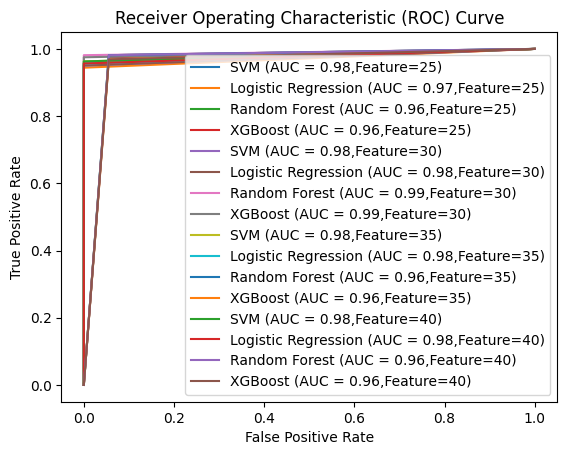

In [52]:
models = {
    "SVM": SVC(kernel="linear"),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

results = pd.DataFrame(columns=['Model', 'Features'])
# model = SVC(kernel="linear")
model = LogisticRegression()
# model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = XGBClassifier()

for feature_count in range(25,41,5):
    rfe = RFE(estimator=model, n_features_to_select=feature_count)
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    selected_feature_indices = rfe.support_
    selected_feature_names = pd.DataFrame(normalized_train_c.iloc[selected_feature_indices,0])
    feature_ranking = rfe.ranking_

    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
    # rfe.support_: The mask of selected features.
    # rfe.ranking_: The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature.
    # Selected (i.e., estimated best) features are assigned rank 1.

    for test_model_name in ["SVM", "Logistic Regression", "Random Forest", "XGBoost"]:
        test_model=models[test_model_name]
        test_model.fit(X_train_rfe, y_train)
        train_accuracy_cv = cross_val_score(test_model, X_train_rfe, y_train, cv=5, scoring='accuracy').mean()

        X_test_rfe = rfe.transform(X_test)
        y_pred = test_model.predict(X_test_rfe)

        X_test_df = pd.DataFrame(X_test)
        incorrect_predictions = X_test_df.loc[y_pred != y_test]
        incorrect_indices = X_test_df.index[y_pred != y_test]

        accuracy_test = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred) #1 表示完美預測，0 表示模型的性能與隨機預測相當，而 -1 表示完全相反的預測。
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{test_model_name} (AUC = {roc_auc:.2f},Feature={feature_count})')

        new_row = {
            'Model': test_model_name, 
            'Features': feature_count,
            'f1_score': f1,
            'AUC': roc_auc,
            'Precision': precision,
            'Accuracy': (train_accuracy_cv + accuracy_test) / 2,
            'Train Accuracy (Cross-Validation)': train_accuracy_cv,
            'Test Accuracy': accuracy_test,
            'difference': train_accuracy_cv - accuracy_test,
            'J-index': recall + accuracy_test - (1 - recall) - 1,
            'Selected Features': selected_feature_names,
            'Incorrect Predictions': len(incorrect_indices)
        }

        results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

        
        print('Selected Features:',selected_feature_names)
        

plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()

In [35]:
results.to_csv('../result/RFE_0.35_Hyper&TSS.csv', index=False)

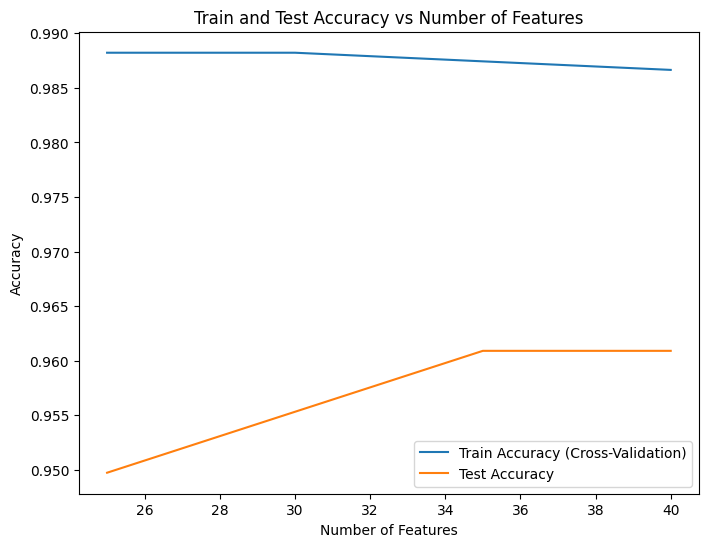

In [53]:
model_results = results[results['Model']=="Logistic Regression"]

plt.figure(figsize=(8, 6))
plt.plot(model_results['Features'], model_results['Train Accuracy (Cross-Validation)'], label='Train Accuracy (Cross-Validation)')
plt.plot(model_results['Features'], model_results['Test Accuracy'], label='Test Accuracy')

plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs Number of Features')

plt.legend()

plt.show()


1. 剩下40個做 RFECV  
結果: 數量太多無法確定最佳特徵數
2. 40個做GO分群再用RFECV  
第1群:12  
第2群:11  
第3群:5  
第4群:11
* 少一個是缺 TRABD(正常，在計算相似度就沒有了)

In [55]:
method1_gene = pd.read_csv("../result/RFE_method1/RFE_gene_40.csv")
select_hyper_TSS = select_hyper_TSS[select_hyper_TSS['ID'].isin(method1_gene['ID'])]

# GO轉 Entrez ID有換別名
select_hyper_TSS[select_hyper_TSS['gene'] == 'GRASP'] = 'TAMALIN'
select_hyper_TSS[select_hyper_TSS['gene'] == 'SLC9A3R1'] = 'NHERF1'

# MIR1204、TRABD 沒有出現在4群中(正常，在計算相似度就沒有了)
cluster_1 = pd.read_csv('../result/wards_cluster/gene_clusters_1.csv')
cluster_1 = select_hyper_TSS[select_hyper_TSS['gene'].isin(cluster_1['Gene'])]

cluster_2 = pd.read_csv('../result/wards_cluster/gene_clusters_2.csv')
cluster_2 = select_hyper_TSS[select_hyper_TSS['gene'].isin(cluster_2['Gene'])]

cluster_3 = pd.read_csv('../result/wards_cluster/gene_clusters_3.csv')
cluster_3 = select_hyper_TSS[select_hyper_TSS['gene'].isin(cluster_3['Gene'])]

cluster_4 = pd.read_csv('../result/wards_cluster/gene_clusters_4.csv')
cluster_4 = select_hyper_TSS[select_hyper_TSS['gene'].isin(cluster_4['Gene'])]

cluster_1.to_csv("../result/RFE_method1/40_GOcluster1.csv", index=False)
cluster_2.to_csv("../result/RFE_method1/40_GOcluster2.csv", index=False)
cluster_3.to_csv("../result/RFE_method1/40_GOcluster3.csv", index=False)
cluster_4.to_csv("../result/RFE_method1/40_GOcluster4.csv", index=False)


In [59]:
data=cluster_1

In [62]:
normalized_train_c = normalized_train_c[normalized_train_c['Unnamed: 0'].isin(data['ID'])]
X_train = normalized_train_c.iloc[:, 1::2]
x = [X_train.iloc[:, i].values.flatten().tolist() for i in range(895)]
y = [(0 if (i < 47) or (i > 444 and i < 495) else 1) for i in range(895)]

In [ ]:
def moving_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

2
Optimal Number of Features: 6
cross validation acc 0.9743078859060403
3
Optimal Number of Features: 10
cross validation acc 0.9776548225629055
4
Optimal Number of Features: 9
cross validation acc 0.9765524903907751
5
Optimal Number of Features: 6
cross validation acc 0.9776536312849162
6
Optimal Number of Features: 9
cross validation acc 0.9765473527218494
7
Optimal Number of Features: 6
cross validation acc 0.976544924071991
8
Optimal Number of Features: 9
cross validation acc 0.9776685167310167
9
Optimal Number of Features: 9
cross validation acc 0.9765544332210998
10
Optimal Number of Features: 9
cross validation acc 0.9776779026217228


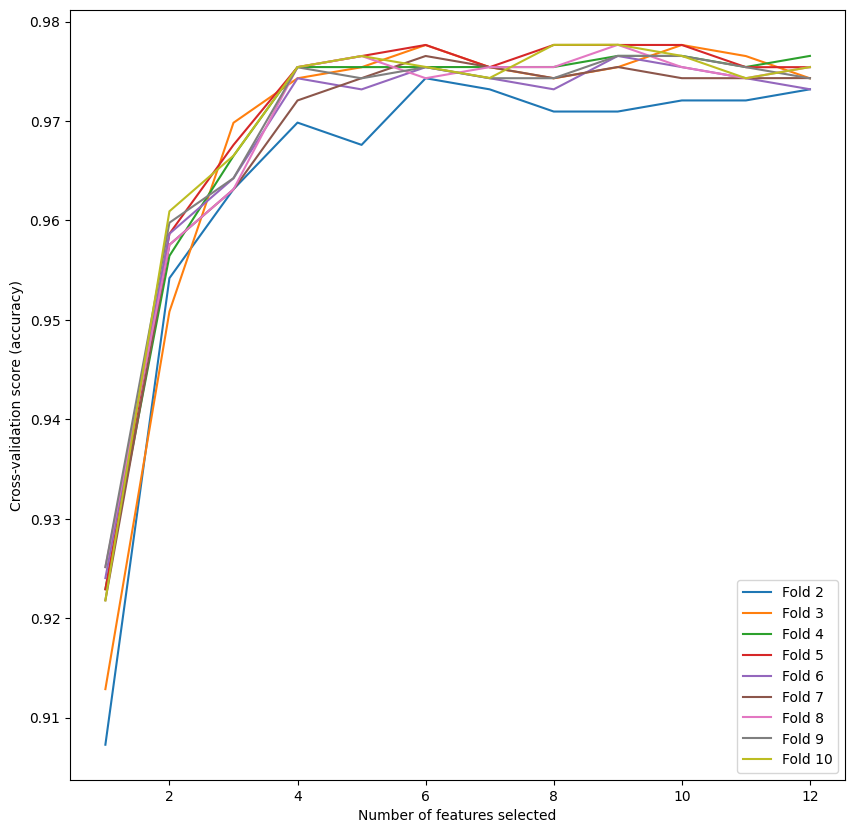

In [65]:
logreg_clf = LogisticRegression()
model=logreg_clf

plt.figure(figsize=(10, 10))
for fold in range(2,11):
    stratified_kfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
    print(stratified_kfold.get_n_splits(x, y))

    rfecv = RFECV(estimator=model, step=1, cv=stratified_kfold, scoring='accuracy')
    fitted_rfecv = rfecv.fit(x, y)

    print("Optimal Number of Features:", fitted_rfecv.n_features_)
    print("cross validation acc", max(fitted_rfecv.cv_results_['mean_test_score']))

    x_val = range(1, len(fitted_rfecv.cv_results_['mean_test_score']) + 1)
    y_val = fitted_rfecv.cv_results_['mean_test_score']

    # Smooth the curve if needed
    # window_size = 10
    # smoothed_y = moving_average(y_val, window_size)
    # plt.plot(x_val[window_size - 1:], smoothed_y, label=f"Fold {fold}")

    # original curve
    plt.plot(x_val, y_val, label=f"Fold {fold}")
        
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.legend(loc="lower right")
plt.show()



In [ ]:
pd.DataFrame(X_train).to_csv("../result/traindata.csv",index=False)

In [ ]:
print(pd.DataFrame(x).shape,pd.DataFrame(y).shape)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# 初始化模型
model = XGBClassifier()  # 請替換成你實際使用的模型

# 將資料分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 初始化 StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 進行交叉驗證並繪製AUC-ROC曲線
for train_index, test_index in stratified_kfold.split(x, y):
    X_train_fold, X_val_fold = pd.DataFrame(x).iloc[train_index], pd.DataFrame(x).iloc[test_index]
    y_train_fold, y_val_fold = pd.DataFrame(y).iloc[train_index], pd.DataFrame(y).iloc[test_index]

    # 使用 RFE 選擇特徵
    rfe = RFE(estimator=model, n_features_to_select=3)
    X_train_rfe = rfe.fit_transform(X_train_fold, y_train_fold)

    # 訓練模型
    model.fit(X_train_rfe, y_train_fold)

    # 獲取模型預測的概率
    y_val_prob = model.predict_proba([X_val_fold])[:, 1]

    # 計算ROC曲線
    fpr, tpr, _ = roc_curve(y_val_fold, y_val_prob)
    roc_auc = auc(fpr, tpr)

    # 繪製ROC曲線
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')

# 設置圖表標籤
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC 曲線')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# 初始化模型
model = SVC(probability=True)  # 請替換成你實際使用的模型

# 將資料分為訓練集和測試集
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 初始化 StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 進行交叉驗證並繪製AUC-ROC曲線
for train_index, test_index in stratified_kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = pd.DataFrame(x).iloc[train_index], pd.DataFrame(x).iloc[test_index]
    y_train_fold, y_val_fold = pd.DataFrame(y).iloc[train_index], pd.DataFrame(y).iloc[test_index]
    print("X_val_fold:",X_val_fold)
    # 訓練模型
    model.fit(X_train_fold, y_train_fold)

    # 獲取模型預測的概率
    y_val_prob = model.predict_proba(X_val_fold)[:, 1]

    # 計算ROC曲線
    fpr, tpr, _ = roc_curve(y_val_fold, y_val_prob)
    roc_auc = auc(fpr, tpr)

    # 繪製ROC曲線
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')

# 設置圖表標籤
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC 曲線')
plt.legend(loc='lower right')
plt.show()
